<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer

print(tf.__version__)

1.15.0


### Import the  Boston Housing dataset.

The Boston Housing dataset comes with the Keras library, so use Keras to import it into your notebook.

In [2]:
# Load housing data.
boston_housing = keras.datasets.boston_housing
(x_train_bh, y_train_bh), (x_test_bh, y_test_bh) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [30]:
x_train_bh.shape

(404, 13)

In [31]:
x_test_bh.shape

(102, 13)

### Normalize the data.

All features should have roughly the same scale.

In [0]:
normalizer = Normalizer()

In [0]:
x_train_bh = normalizer.fit_transform(x_train_bh)
x_test_bh = normalizer.transform(x_test_bh)

### Instantiate a model object and use model.add() to add layers to your model.

Since this is a regression model you will have a single output node in the final layer. Use activation functions that are appropriate for this task.

In [0]:
model = keras.Sequential()

In [0]:
model.add(Dense(1, input_dim=13, activation='relu'))
model.add()

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

### Load and preprocess the image data.

(similar to how we preprocessed the MNIST data in class)

In [3]:
# Load data.
fashion_mnist = keras.datasets.fashion_mnist
(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# Each category of image corresponds to a type of clothing or accessory.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

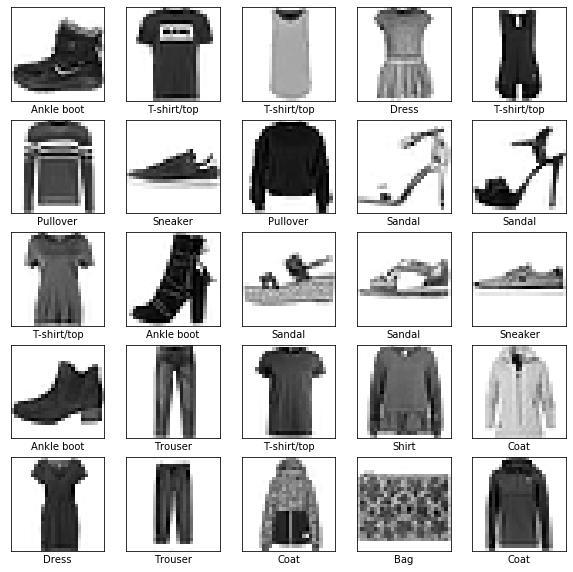

In [5]:
# Preview sample data.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_f[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_f[i]])
plt.show()

In [6]:
# Check pre-scaling max value.
np.amax(x_train_f)

255

In [0]:
# Scale values.
x_train_f = x_train_f / 255.0
x_test_f = x_test_f / 255.0

In [8]:
# Calculate post-scaling maximum (for train set).
np.amax(x_train_f)

1.0

In [9]:
# Check post-scaling maximum for test set.
np.amax(x_test_f)

1.0

### One-hot encode your category labels.

In [10]:
# This isn't actually necessary.
y_train_f[:6]

array([9, 0, 0, 3, 0, 2], dtype=uint8)

### Define neural network architecture.

Make sure to have your final layer have as many nodes as the number of classes that you want to predict.

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Try different hyperparameters.

What is the highest accuracy that you are able to achieve?

In [13]:
model.fit(x_train_f, y_train_f, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.5040 - acc: 0.8223
Epoch 2/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3764 - acc: 0.8652
Epoch 3/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3356 - acc: 0.8768
Epoch 4/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3116 - acc: 0.8861
Epoch 5/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.2952 - acc: 0.8911
Epoch 6/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2810 - acc: 0.8949
Epoch 7/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2677 - acc: 0.9007
Epoch 8/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.2582 - acc: 0.9040
Epoch 9/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2481 - acc: 0.9069
Epoch 10/10
60000/60000 [==============================] - 

In [14]:
train_loss, train_acc = model.evaluate(x_train_f, y_train_f, verbose=2)
print('\nTrain accuracy:', train_acc)

60000/60000 - 2s - loss: 0.2214 - acc: 0.9191

Train accuracy: 0.9191


In [15]:
test_loss, test_acc = model.evaluate(x_test_f, y_test_f, verbose=2)
print('\nTest accuracy:', test_acc)

10000/10000 - 0s - loss: 0.3329 - acc: 0.8846

Test accuracy: 0.8846


In [0]:
predictions_f = model.predict(x_test_f)

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

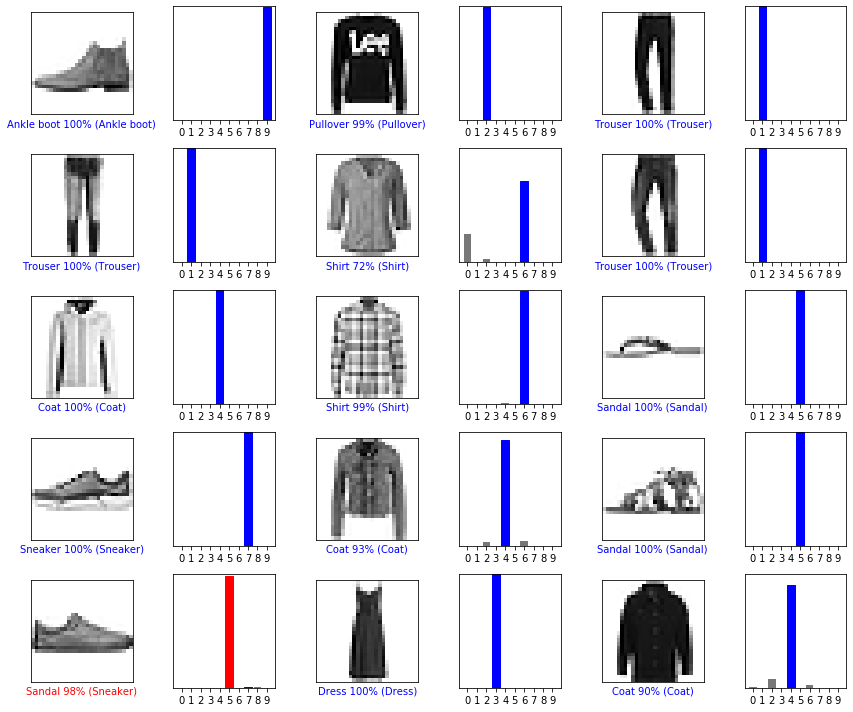

In [18]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions_f[i], y_test_f, x_test_f)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions_f[i], y_test_f)
plt.tight_layout()
plt.show()

### Graph the model's loss or train/validation accuracies by epoch.

Use the history object that is returned from model.fit.

In [19]:
model.history

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.